20213043 이세현

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! ls "/content/gdrive/My Drive"

 2021학년도   2022학년도  'Colab Notebooks'   서명.png	 ua.base   ua.test


In [3]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
train = pd.read_csv("/content/gdrive/My Drive/ua.base", sep="\t", names=['user', 'movie', 'rating', 'timestamp'])
test = pd.read_csv("/content/gdrive/My Drive/ua.test", sep="\t", names=['user', 'movie', 'rating', 'timestamp'])

In [5]:
train

,user,movie,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
90565,943,1047,2,875502146
90566,943,1074,4,888640250
90567,943,1188,3,888640250
90568,943,1228,3,888640275


In [6]:
items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])

items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

In [7]:
rank = 10 # 사용자와 아이템 vector의 차원
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

기본 Matrix Factorization 구현

In [8]:
optimizer = torch.optim.Adam([P, Q], lr=0.1)

X = []
Y = []
Y_test = []

for epoch in range(1001):
    hypothesis = torch.sum(P[items] * Q[users], dim=1)
    cost = F.mse_loss(hypothesis, ratings)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    with torch.no_grad():
        X.append(epoch)
        Y.append(cost.item())

        h_test = torch.sum(P[items_test] * Q[users_test], dim=1)
        cost_test = F.mse_loss(h_test, ratings_test)
        Y_test.append(cost_test.item())

        if epoch % 100 == 0:
            print("epoch: {}, cost: {:.6f}".format(epoch, cost.item()))

epoch: 0, cost: 23.584047
epoch: 100, cost: 0.569522
epoch: 200, cost: 0.495788
epoch: 300, cost: 0.472501
epoch: 400, cost: 0.461865
epoch: 500, cost: 0.455485
epoch: 600, cost: 0.451447
epoch: 700, cost: 0.448792
epoch: 800, cost: 0.446920
epoch: 900, cost: 0.445491
epoch: 1000, cost: 0.444352


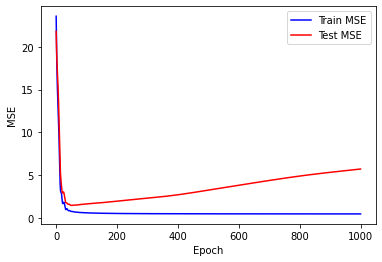

In [9]:
plt.plot(X, Y, c="blue", label="Train MSE")
plt.plot(X, Y_test, c="red", label="Test MSE")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Regularization

In [10]:
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

optimizer = torch.optim.Adam([P, Q], lr=0.1)
lambda1 = 0.0001
lambda2 = 0.0001
X = []
Y = []
Y_test = []

for epoch in range(1001):
    hypothesis = torch.sum(P[items] * Q[users], dim=1)
    cost = F.mse_loss(hypothesis, ratings)
    loss = cost + lambda1 * torch.sum(P**2)+lambda2 * torch.sum(Q**2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        X.append(epoch)
        Y.append(cost.item())

        h_test = torch.sum(P[items_test] * Q[users_test], dim=1)
        cost_test = F.mse_loss(h_test, ratings_test)
        Y_test.append(cost_test.item())

        if epoch % 100 == 0:
            print("epoch: {}, cost: {:.6f}, test_cost: {:.6f}".format(epoch, cost.item(), cost_test.item()))

epoch: 0, cost: 23.651836, test_cost: 21.642691
epoch: 100, cost: 0.703965, test_cost: 1.057757
epoch: 200, cost: 0.649117, test_cost: 1.057361
epoch: 300, cost: 0.635435, test_cost: 1.057677
epoch: 400, cost: 0.629814, test_cost: 1.057085
epoch: 500, cost: 0.627703, test_cost: 1.057066
epoch: 600, cost: 0.626793, test_cost: 1.057050
epoch: 700, cost: 0.626388, test_cost: 1.056720
epoch: 800, cost: 0.626216, test_cost: 1.056426
epoch: 900, cost: 0.626126, test_cost: 1.056266
epoch: 1000, cost: 0.626066, test_cost: 1.056150


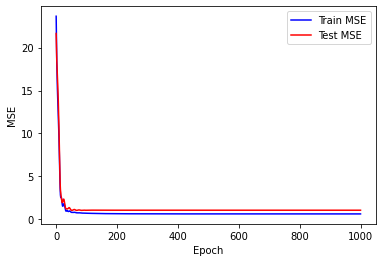

In [11]:
plt.plot(X, Y, c="blue", label="Train MSE")
plt.plot(X, Y_test, c="red", label="Test MSE")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Bias

In [12]:
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

lambda3 = 0.001
lambda4 = 0.001

bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)

mean = ratings.mean()

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr=0.1)

X = []
Y = []
Y_test = []

for epoch in range(1001):
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
    cost = F.mse_loss(hypothesis, ratings)
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        X.append(epoch)
        Y.append(cost.item())

        h_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + bias_item[items_test] + bias_user[users_test]
        cost_test = F.mse_loss(h_test, ratings_test)
        Y_test.append(cost_test.item())

        if epoch % 100 == 0:
            print("epoch: {}, cost: {:.6f}, test_cost: {:.6f}".format(epoch, cost.item(), cost_test.item()))

epoch: 0, cost: 13.461679, test_cost: 10.513803
epoch: 100, cost: 0.635416, test_cost: 0.925330
epoch: 200, cost: 0.608710, test_cost: 0.916375
epoch: 300, cost: 0.604833, test_cost: 0.914176
epoch: 400, cost: 0.603335, test_cost: 0.913296
epoch: 500, cost: 0.602907, test_cost: 0.912871
epoch: 600, cost: 0.602710, test_cost: 0.911635
epoch: 700, cost: 0.602495, test_cost: 0.910378
epoch: 800, cost: 0.602268, test_cost: 0.909757
epoch: 900, cost: 0.602090, test_cost: 0.909600
epoch: 1000, cost: 0.602009, test_cost: 0.909738


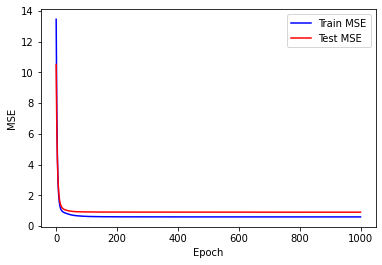

In [13]:
plt.plot(X, Y, c="blue", label="Train MSE")
plt.plot(X, Y_test, c="red", label="Test MSE")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend()
plt.show()